In [10]:
import pandas as pd
import numpy as np

import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

import dtale
import pywedge as pw

from altair import Chart, X, Y, repeat
from common import display_side_by_side

from utils.common_transformers import DateHandler, DateDiff

In [11]:
df = pd.read_json("../intermediate_data/null_outlier_handled.json")

target_col = ["time_spent"]

copy = df.copy()

# Basic EDA

## Overview

In [7]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5429 entries, 0 to 5428
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   session_id             5429 non-null   object        
 1   client_agent           5269 non-null   object        
 2   device_details         5429 non-null   object        
 3   date                   5429 non-null   datetime64[ns]
 4   purchased              5429 non-null   int64         
 5   added_in_cart          5429 non-null   int64         
 6   checked_out            5429 non-null   int64         
 7   session_number         5429 non-null   int64         
 8   time_spent             5429 non-null   float64       
 9   time_spent_is_outlier  5429 non-null   bool          
 10  client_agent_is_null   5429 non-null   bool          
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 434.7+ KB


None

In [8]:
df.describe()

,purchased,added_in_cart,checked_out,session_number,time_spent
count,5429.000000,5429.000000,5429.000000,5429.000000,5429.000000
mean,0.159145,0.162092,0.017499,1072.835329,663.194292
std,0.365845,0.368570,0.131132,1436.351474,1713.671664
min,0.000000,0.000000,0.000000,11.000000,14.400000
25%,0.000000,0.000000,0.000000,121.000000,22.699000
50%,0.000000,0.000000,0.000000,517.000000,98.312000
75%,0.000000,0.000000,0.000000,1397.000000,600.463000
max,1.000000,1.000000,1.000000,7722.000000,38494.025000


In [9]:
df.head()

,session_id,client_agent,device_details,date,purchased,added_in_cart,checked_out,session_number,time_spent,time_spent_is_outlier,client_agent_is_null
0,57f879e70d3c5fc2a98102d64c9fd84e,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-22,1,0,0,715,236.886,False,False
1,a5442b0c7c33d0a811e7661e556b2de8,Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-27,1,0,0,55,1277.455,False,False
2,305cb1486ed8610c00b37007926cb2c4,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,2019-08-01,0,0,0,11,21.704,False,False
3,f2c1ecc9993f0071df91ba178450498c,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,2019-12-30,0,1,0,2794,455.201,False,False
4,e460830ae295e55d2216ebdc761ab9a6,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like ...,iPhone - Web,2019-09-10,0,0,0,3674,1164.877,False,False


In [12]:
df.drop(["session_id","session_number"],axis=1,inplace=True)

In [28]:
cat_cols = df.select_dtypes(exclude=np.number).columns
for col in cat_cols:
    print(col)
    
    vc = pd.DataFrame(df[col].value_counts(dropna=False,normalize=True))
    vc.columns = ["% Count"]
    vc.sort_values("% Count",ascending=False)
    print(f"No of unique categories : {len(vc)}")
    display(vc.head(7))

client_agent
No of unique categories : 699


,% Count
"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Mobile/11D201",0.038497
Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7.0; Touch; rv:11.0) like Gecko,0.030024
NaN,0.029471
Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko,0.027261
Product/4.2.0 iPhone/7.1.1,0.026893
Product/4.7.0 iPhone/8.1.2,0.026524
"Mozilla/5.0 (iPhone; CPU iPhone OS 8_1 like Mac OS X) AppleWebKit/600.1.4 (KHTML, like Gecko) Mobile/12B411",0.020998


device_details
No of unique categories : 17


,% Count
iPhone - iOS,0.279057
Desktop - Chrome,0.150120
iPhone - Web,0.122490
Android Phone - Android,0.060048
Desktop - Safari,0.057653
Desktop - IE,0.053785
iPad - Web,0.053233


date
No of unique categories : 342


,% Count
2019-09-05,0.007552
2019-12-01,0.007368
2019-12-23,0.007184
2019-09-02,0.007184
2019-09-06,0.006999
2019-09-01,0.006815
2019-09-15,0.006815


time_spent_is_outlier
No of unique categories : 2


,% Count
False,0.876589
True,0.123411


client_agent_is_null
No of unique categories : 2


,% Count
False,0.970529
True,0.029471


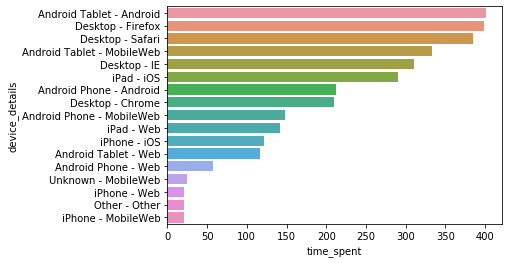

In [52]:
a=pd.DataFrame(df.groupby("device_details")["time_spent"].median()).sort_values("time_spent",ascending=False)
a=a.reset_index()
sns.barplot(x="time_spent",y="device_details",data=a,)

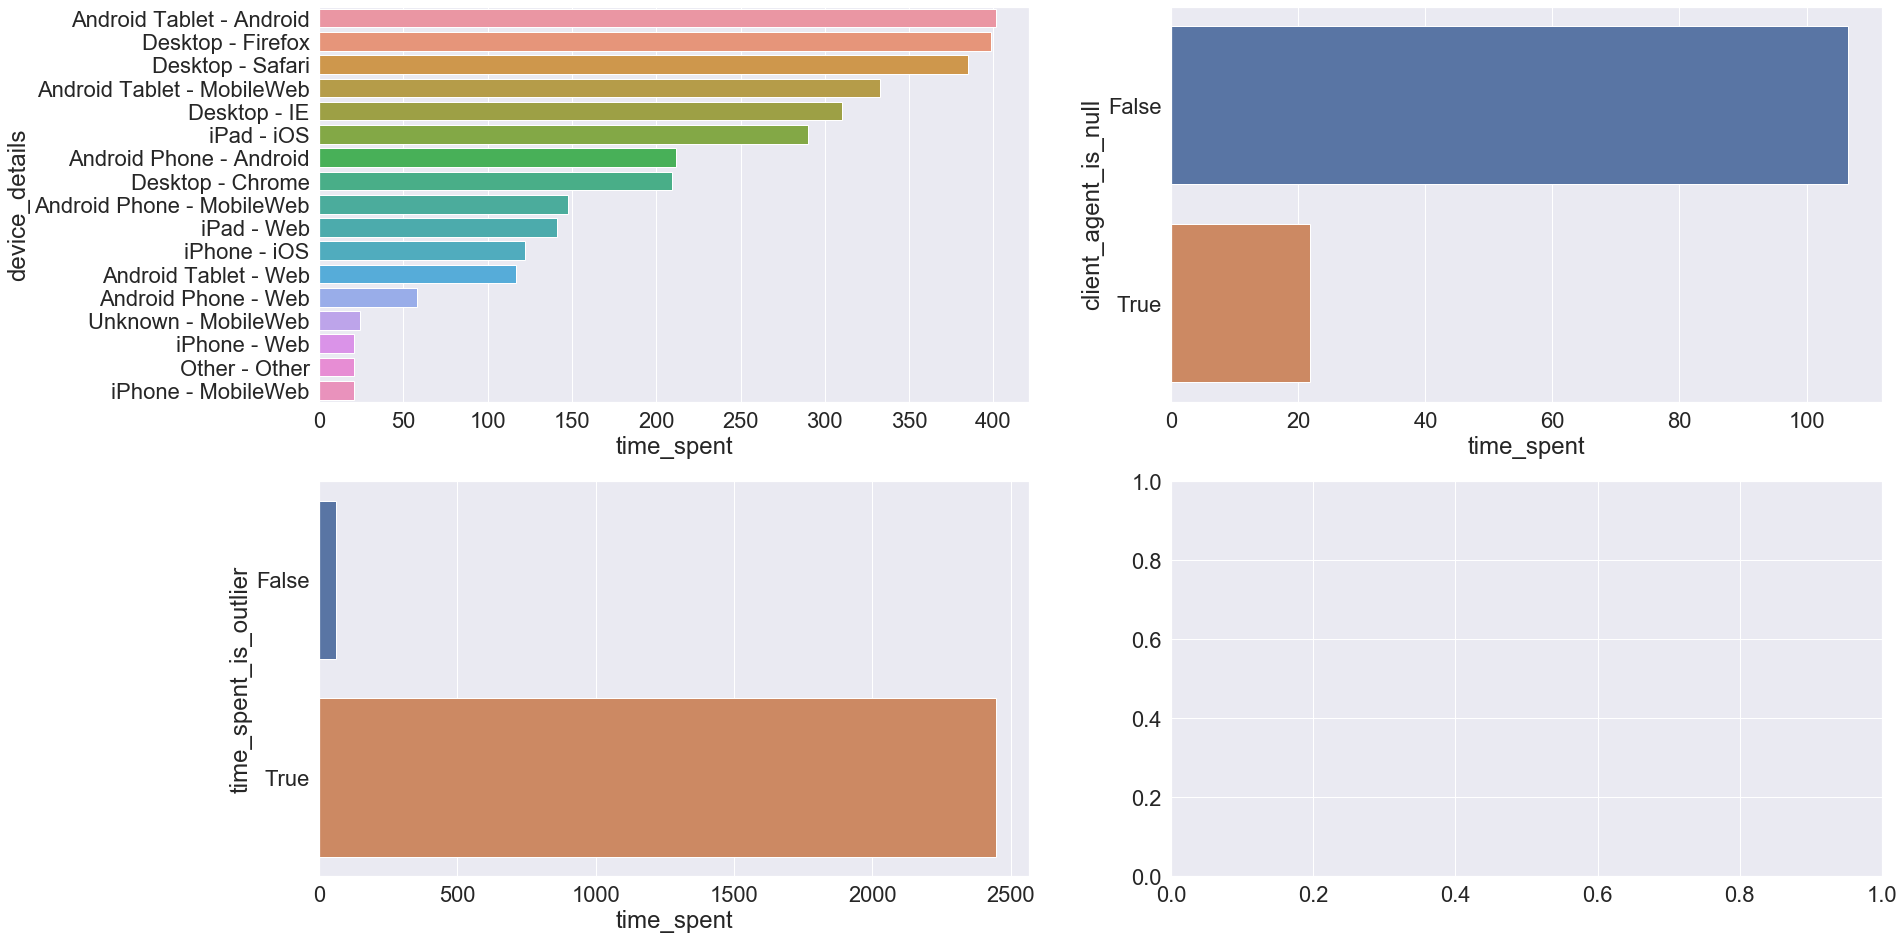

In [75]:
cat_cols = list(set(cat_cols).difference(set(["client_agent","date"])))
num_rows = int(np.ceil(len(cat_cols) / 2))

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(28,num_rows*8))
ax= axes.flatten()

for index,col in enumerate(cat_cols,0):
    axes = ax[index]
    a=pd.DataFrame(df.groupby(col)["time_spent"].median()).sort_values("time_spent",ascending=False)
    a=a.reset_index()
    sns.set(font_scale = 2)
    sns.barplot(x="time_spent",y=col,data=a,ax=axes,orient="h")
    
  

<string>:6: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

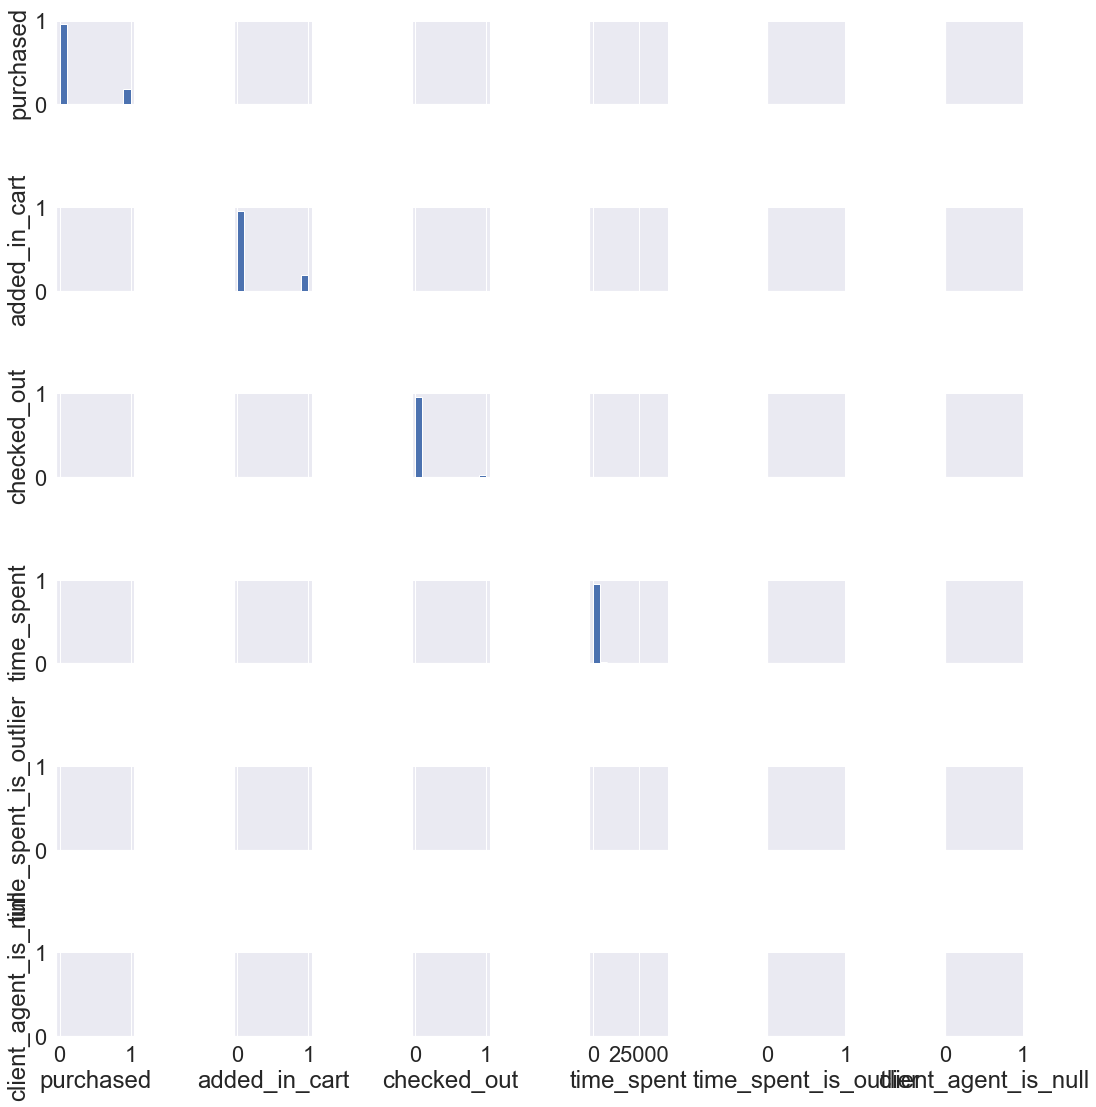

In [68]:
#sns.pairplot(df)

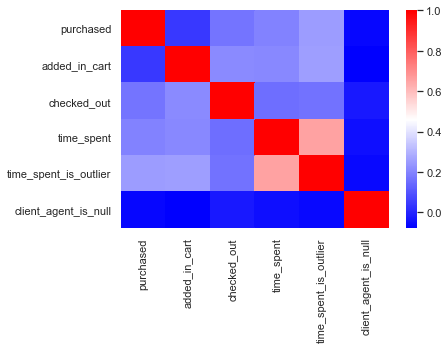

In [77]:
sns.set(font_scale = 1)
sns.heatmap(df.corr(),cmap="bwr")

In [13]:
df.head(n=2)

,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent,time_spent_is_outlier,client_agent_is_null
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-22,1,0,0,236.886,False,False
1,Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-27,1,0,0,1277.455,False,False


In [14]:
df = DateHandler(["date"],date_format="%Y-%m-%d",drop_original_col=False).fit_transform(df)

In [15]:
df = DateDiff(["date"],date_format="%Y-%m-%d",drop_original_col=True).fit_transform(df)

In [16]:
df.head()

,client_agent,device_details,purchased,added_in_cart,checked_out,time_spent,time_spent_is_outlier,client_agent_is_null,date_day,date_month,date_year,date_day_name,date_day_num,date_is_weekend,date_close_to_month_start_end,date_is_holiday,date_quater,date_date_diff
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,1,0,0,236.886,False,False,22,1,2020,Wednesday,2,0,0,False,1,261
1,Product/8.0 iPhone/8.1.3,iPhone - iOS,1,0,0,1277.455,False,False,27,2,2020,Thursday,3,0,1,False,1,297
2,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,0,0,0,21.704,False,False,1,8,2019,Thursday,3,0,1,False,3,87
3,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,0,1,0,455.201,False,False,30,12,2019,Monday,0,0,1,False,4,238
4,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like ...,iPhone - Web,0,0,0,1164.877,False,False,10,9,2019,Tuesday,1,0,0,False,3,127


In [17]:
df.drop(["client_agent","device_details","time_spent_is_outlier","date_day_name"],inplace=True,axis=1)

In [18]:
df.to_json("../intermediate_data/basic_fe.json")

# Feature Engineering & Advanced EDA 

In [24]:
dtale.show(df,ignore_duplicate=True)

In [21]:
mc=pw.Pywedge_Charts(df.dropna(),c=None,y="Final_Marks")
charts = mc.make_charts();

HTML(value='<h2>Pywedge Make_Charts </h2>')

HTML(value='<h4><em>Charts compiled by Pywedge make_charts </em></h4>')

## Discrete Target

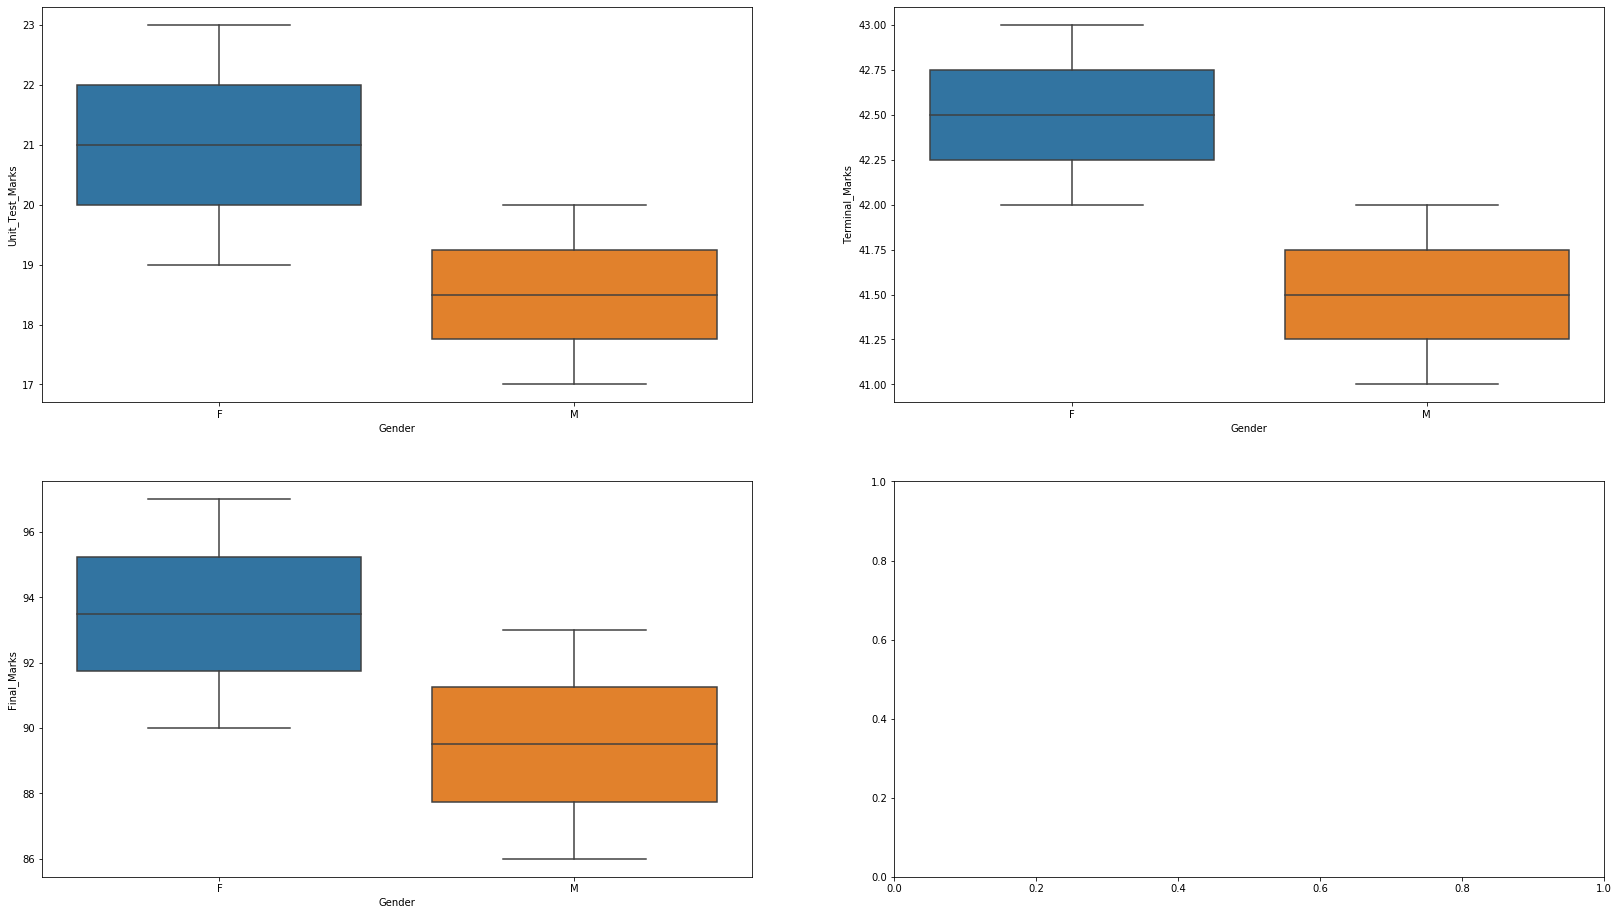

In [107]:
target_col = "Gender"
num_cols = df.select_dtypes(include=np.number)

num_rows = int(np.ceil(len(num_cols.columns) / 2))

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(28,num_rows*8))
ax= axes.flatten()
for index,col in enumerate(num_cols.columns,0):
    axes = ax[index]
    sns.boxplot(data=df,x=target_col,y=col,ax=axes,)
  

In [172]:
cat_cols_names = list(set(cat_cols.columns).difference(set([target_col])))
dfs = []
for index,col in enumerate(cat_cols_names,0):
    a = pd.DataFrame(df.groupby("Gender")[col].value_counts(dropna=False,normalize=True))
    a.columns=["% Count"]
    dfs.append(a)

In [173]:
display_side_by_side(*dfs)

% Count 
 
 
 Gender 
 Performance 
 
 
 
 
 
 F 
 NaN 
 0.5 
 
 
 A+ 
 0.5 
 
 
 M 
 A 
 0.5 
 
 
 B 
 0.5

## Continuous Target

### Normality Test

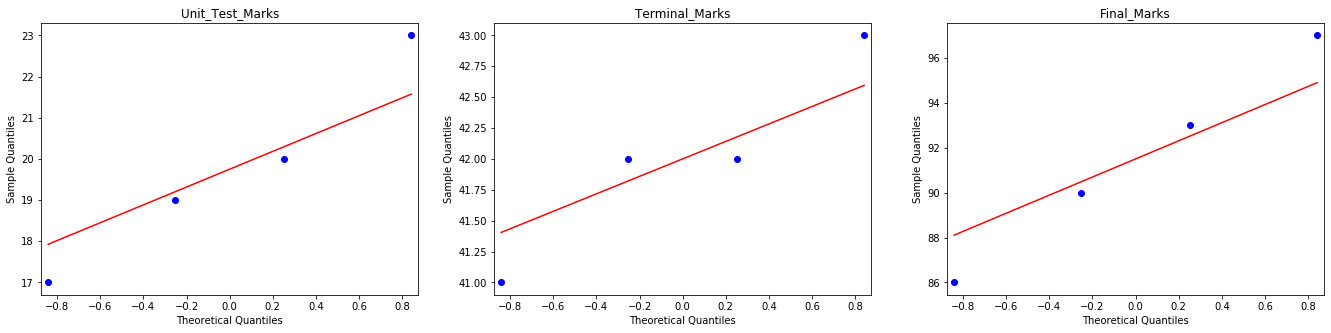

In [22]:
numeric= df.select_dtypes(include=[int,float])
num_numeric_cols = numeric.shape[1]
num_rows = int(np.ceil(num_numeric_cols / 3))

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(23,5))
ax= axes.flatten()
for index,col in enumerate(numeric.columns,0):
    axes = ax[index]
    axes.set_title(col)
    qqplot(numeric[col], line='s',ax=axes)
    

# Feature Engineering